In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [7]:
churn_data = pd.read_csv('/home/elliot/PycharmProjects/CSC 495 - Telecom Customer Churn/Datasets/telecom_churn_Processed.csv')

X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)

In [8]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

y_pred_dt = decision_tree.predict(X_test)
y_pred_train_dt = decision_tree.predict(X_train)

In [9]:
dt_as = metrics.accuracy_score(y_test, y_pred_dt)
dt_as_train = metrics.accuracy_score(y_train, y_pred_train_dt)

print(f"Accuracy score for test data : {dt_as}")
print(f"Accuracy score for train data : {dt_as_train}")

Accuracy score for test data : 0.7298578199052133
Accuracy score for train data : 1.0


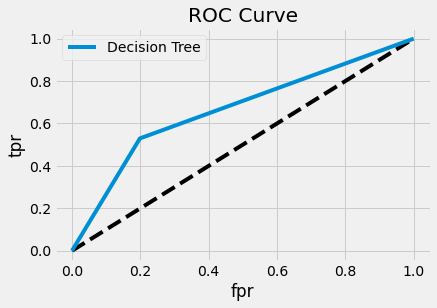

In [10]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_dt)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'Decision Tree')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();
